## OpenStreetMap Data Case Study: Udacity’s Data Analyst Nanodegree, Project 3
## Report

### Section 1: Introduction
#### Resources Used
- Sample projects: 
    - https://github.com/allanbreyes/udacity-data-science/tree/master/p2
    - https://gist.github.com/carlward/54ec1c91b62a5f911c42#file-sample_project-md
- http://stackoverflow.com/questions/613183/sort-a-python-dictionary-by-value
- https://discussions.udacity.com/t/iterative-parsing-using-iterparse/167980/2

#### Map Area: London and its Surrounding Areas, England
- https://mapzen.com/data/metro-extracts/

#### Objective
- Audit and clean the XML Dataset in Python
- Convert from XML to CSV
- Load dataset into SQL and perform queries to extract information from the dataset

### Section 1: Data Auditing and Cleaning
Investigate the most common tags in the dataset. Most common tags were found to be:


    [('note', 1699), ('ref', 1746), ('landuse', 1831), ('source:building', 1890), ('foot', 2092), ('operator', 2154), ('surface', 2294), ('barrier', 2627), ('lit', 2733), ('amenity', 2872), ('addr:city', 2924), ('maxspeed', 2959), ('natural', 3859), ('addr:street', 5329), ('addr:housenumber', 5621), ('created_by', 6417), ('source', 12896), ('name', 13067), ('building', 16914), ('highway', 17564)]


For the most common tag values above, I investigated the attribute values to understand the data cleaning tasks required by creating a defaultdict to store values and frequencies of the tags highway, building, street and source.

#### The Highway Tag
Printing out the DefaultDict for the Highway Tag showed that the data was
- clean.
- valid --> all entries are expected for a highway
- and consistent. There is only a single instance for each highway attribute value.

Snippet of highway types:

    access: 2
    bridleway: 174
    bus_guideway: 1
    bus_stop: 1125
    construction: 12
    corridor: 1
    crossing: 514
    cycleway: 411


#### The Building Tag
Printing out the DefaultDict for the Building Tag showed that the data could be made more consistent and uniform by consolidating values such as 'garage' and 'garages' and 'boat_house' and 'boathouse' as one. 

Cleaning Performed:
- parsed the XML File, cleaned the building values and wrote the corrected XML document out to file.

Consolidated values:

    boat_house & boathouse --> boathouse
    garage & garages --> garage

#### The Street Tag
Some cleaning of the Street Data Required.
- Multiple instances of the same street type need to be consolidated:
    - Ave, ave, Avenue
    - Rd, road, Road, ROAD
    - St, Street, street
    
Cleaning Performed:
- consolidated all instances of Avenue, Road and Street to Avenue, Road and Street using a mapping dicitionary and looping through the the values of the street tag.

#### The Source Tag
Some cleaning of the Source Data Required. There were two problems that needed to be addressed:
- Some values had multiple sources. In this case I split the string into multiple values using regex and created separate entries.
- Standardised the names using a mapping key. I did this in two iterative steps.
    - First I gathered together the major information sources and standardised their names.
    - On a second pass, for the minor information sources not included in the mapping dictionary, I reassigned the source value to other.
    
The result was that the number of sources was reduced down to the following list whilst still preserving the major information sources. 

    Bing: 5058
    GPS: 632
    Knowledge: 322
    London Borough of Southwark: 1358
    Naptan Import: 859
    NPE: 383
    OS: 2052
    Other: 713
    Photograph: 281
    SAS: 495
    Survey: 1807
    Yahoo: 442
    

### Section 2: Export XML document to CSV 

A script (see the code workbook) was written to prepare the dataset and export it to a CSV.

### Section 3: Inserting CSV into SQL

The python files 
- create_nodes_db.py, 
- create_nodes_tags_db.py, 
- create_ways_db.py and 
- create_ways_tags_db.py 

were created to import the nodes, nodes_tags, ways and ways_tags csvs into SQL (these are included in the same Github repository). The ways_nodes csv was inputted in SQL. 

### Section 4: Data Overview
I performed the following queries in the command line using sqlite3. I have pasted the queries and results into the notebook below for reference. 

**File Size**

- The original file was 2.47 GB.
- After taking every 40th element, the final file used for the project was 60 MB.

**Number of Nodes**

    "select count(id) from nodes" --> 280985

**Number of Ways**

    "select count(id) from ways" --> 40199

**Number of Unique Users**

    "select count(distinct uid) from nodes" --> 3343

    "select count(distinct uid) from ways" --> 1767

**How does contribution from each user vary?**

**Top 10 contributors**

    "create view top_10 contributors as select uid, count(id) as count from nodes group by uid order by count desc limit 10;"

**Sum up the contribution of these top 10 contributors**

    "select uid, sum(count) as sum from top_10_contributors;"

- 76,978 out of a total of 280,895 nodes are made by 10 users. 
- 50 users out of a total of 3343 who contributed to nodes created 169,204 nodes, over half of the total. 

**How many members only contribute one node?**

    "create view one_contribution as select uid, count (id) as count from nodes group by uid having count = 1;"

    "select count(uid) as sum from one_contribution;"

- 1190 users, nearly a third of the total users, have contributed one node to the OSM of London and its surrounding areas.

**Average number of node contributions from each user**

    "select avg(count) from (select uid, count(id) as count from nodes group by uid) as count_all;"

- 84.05

**Create a histogram of node contributions using pandas**

First write file to csv and then import it below into a dataframe.

     # write file to csv
     .mode csv
     .output node_contribution_per_user.csv
     select count(id) from nodes group by uid;
     
The histogram below shows a positively skewed distribution. Most users contribute few nodes with a small minority contributing a large number.

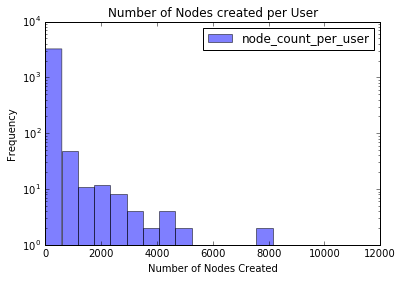

In [293]:
import matplotlib.pyplot as plt
import pandas as pd
% matplotlib inline

df = pd.read_csv('node_contribution_per_user.csv', header=None, names = ['node_count_per_user'])
df
ax = df.plot(kind = 'hist', title = 'Number of Nodes created per User',logy=True,alpha = 0.5, bins = 20)
ax.set(xlabel = 'Number of Nodes Created')

The histogram above showed us the contribution distribution by user. Below I have looked at the contribution distribution over time, to understand when most of the contributions to the London OSM Dataset were made.

It seems like contributions for the number of nodes in London grew steadily up to 2012 but have since declined.

[<matplotlib.text.Text at 0x2187c6d8>, <matplotlib.text.Text at 0x2de8bef0>]

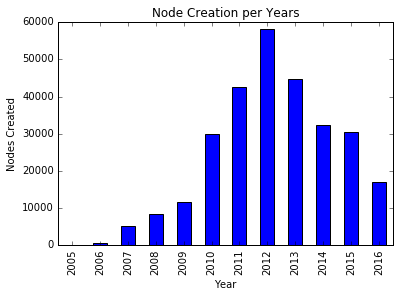

In [317]:
import csv
import re

pattern = re.compile(r'(\w+)')

data = []
with open ('date.csv', 'rb') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        row = str(row)
        result = (pattern.search(row)).group()
        data.append(result)
        
df = pd.DataFrame(data)
ax = df[0].value_counts().sort_index(axis=0, ascending=True).plot(kind = 'bar', title = 'Node Creation per Years')
ax.set(xlabel = 'Year', ylabel = 'Nodes Created')

**How many nodes on average make up a way?**

    query = "select avg(count) from (select ways_tags.id, count(node_id) as count from 
             ways_tags join ways_nodes on ways_tags.id = ways_nodes.id 
             group by ways_tags.id) as subq"

**Result:**
23.1


#### Let's now use the data to understand more about London.

**What are the ten most common amenities?**

    query = "select value, count(value) as count from nodes_tags 
            where key = 'amenity' group by value order by count desc limit 10;"

**Result:**

- post_box,334
- bench,196
- bicycle_parking,151
- pub,138
- restaurant,113
- telephone,97
- cafe,75
- waste_basket,70
- place_of_worship,65
- fast_food,62


#### Additional Ideas

- We saw above that few users contribute a large proportion of the nodes created in the dataset. A SQL query showed that 10 of the top contributors created nearly a quarter of the total nodes. To try to increase the number of contributors, we could look at ways of making it easier to contribute. Perhaps the process could be incorporated into a game such as Pokemon Go, where users who are already roaming the streets are awarded points for identifying and labelling features on the map. 

    - Implemented successfully, this would grant the OSM more data albeit dirty that would require cleaning. 
    - It would likely generate duplicate (possibly different) entries for a given node or way, requiring a method of choosing between these multiple entries. 
    - It would help generate a more complete dataset. 
    - Through redundancy, it could be used to improve the accuracy of the dataset. If there were several identical entries for a node or way then that datapoint could be assumed to be accurate. 
    
- I was impressed by Google's use of computer vision to extract information from their streetview photos and embed them in their maps. Perhaps, users could also share their photographs and algorithms could be developed to extract information from these. 
    - This would require a level of investment and funding hard to come by for an open source project. 
    - Algorithms would need to be developed to extract information from the photographs.
    - In return, the data could be cleaned at acquisition with quality control from a human. 
    - It would also provide a rich dataset, with precise GPS locations for roads and locations. 
- Regarding the dataset, I would be interested in seeing whether way creation activity had increased after 2012 when we saw the beginning of the decline in node creation. Perhaps the contributors changed their focus from creating the map to adding features to it. 




- Data cleaning aims to address imperfections in data quality, of which there are five main features
    - Validity
    - Accuracy
    - Completeness
    - Consistency
    - Uniformity

- Much of the effort above has been directed towards validity - deciding what street name, or building type name is valid and checking that the field values adhere to these constraints. Other work could look at auditing accuracy of data by comparing our dataset to another. We could extract google maps information from the API, and use it as a gold standard dataset to check for accuracy of the Open Street Map Dataset. This would also allow us to check for completeness. 

### Conclusion

- The Open Street Map Data for London was downloaded in XML format, sampled for every 40th element. 
- Some parts of the data were audited and cleaned although cleaning tasks remain. The data was written to a CSV file, loaded into a SQL database (sqlite) and queries were constructed to understand the dataset (the number of nodes, ways, the contribution distributions by user and time) as well as extract information about London. 